In [1]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.vgg19 import VGG19

'''gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
sess_config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7), allow_soft_placement = True)
sess = tf.compat.v1.Session(config=sess_config)
tf.compat.v1.keras.backend.set_session(sess)'''

"gpus = tf.config.experimental.list_physical_devices('GPU')\ntf.config.experimental.set_memory_growth(gpus[0], True)\nsess_config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7), allow_soft_placement = True)\nsess = tf.compat.v1.Session(config=sess_config)\ntf.compat.v1.keras.backend.set_session(sess)"

In [2]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 15
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

In [3]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
# add zoom and vertical flip -> dogs are dogs no matter it is position and facing
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2,
                                                zoom_range = 0.3, 
                                             vertical_flip = True
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [4]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')


nb_train = len(train_generator.filenames)
nb_val = len(validation_generator.filenames)

Found 18522 images belonging to 120 classes.
Found 2058 images belonging to 120 classes.


In [5]:
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)


In [6]:
res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [7]:
res_name[-7:]
len(res_name)

24

In [8]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-7:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
resnet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
Total params: 20,672,696
Trainable params: 10,087,544
Non-trainable params: 10,585,152
_________________________________________________________________


In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=5,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-7,
                                   )

In [12]:
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [13]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(nb_train) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=np.ceil(float(nb_val) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1235.0 steps, validate for 138.0 steps
Epoch 1/100
1235/1235 [==============================] - 244s 197ms/step - loss: 5.0801 - accuracy: 0.0109 - f1_score: 0.0020 - val_loss: 4.7868 - val_accuracy: 0.0131 - val_f1_score: 2.1655e-04
Epoch 2/100
1235/1235 [==============================] - 245s 198ms/step - loss: 4.7860 - accuracy: 0.0112 - f1_score: 5.8082e-04 - val_loss: 4.7859 - val_accuracy: 0.0131 - val_f1_score: 2.1583e-04
Epoch 3/100
1235/1235 [==============================] - 241s 195ms/step - loss: 4.7845 - accuracy: 0.0116 - f1_score: 4.0315e-04 - val_loss: 4.7850 - val_accuracy: 0.0131 - val_f1_score: 2.1583e-04
Epoch 4/100
1235/1235 [==============================] - 253s 205ms/step - loss: 4.7831 - accuracy: 0.0116 - f1_score: 4.0646e-04 - val_loss: 4.7841 - val_accuracy: 0.0131 - val_f1_score: 2.1583e-04
Epoch 5/100
1235/1235 [==============================] - 254s 206ms/step - loss: 4.7816 - accuracy: 0.0114 - 

In [14]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

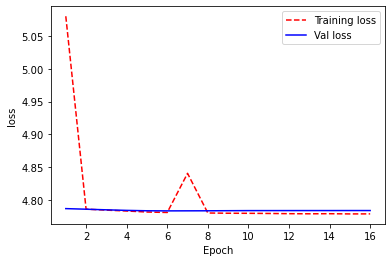

In [15]:
get_diagnostic_plot(model,'loss')

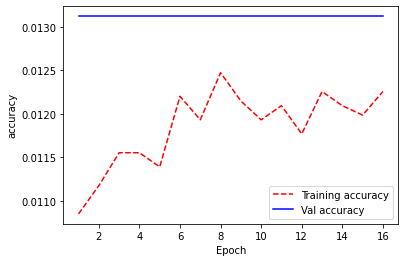

In [16]:
get_diagnostic_plot(model,'accuracy')

In [17]:
save_path = 'G:/Github/Dogs_breed_classification/VGG19_1/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/VGG19_1/assets


Terrible performance.

have to say we may need to just lock the weight for VGG 19

it is too shallow a net to perform the dog task